# **Implement a Deep Reinforcement Learning method for an Acrobot Game**

# **Implement a Deep Reinforcement Learning method for an Acrobot Game**

**Introduction:**

The goal of this project is to implement a Deep Q-Network (DQN) algorithm to learn to play the classic "Acrobot" game in the OpenAI Gym environment. The CartPole game involves balancing a pole on a cart that moves along a track, and the goal is to keep the pole balanced for as long as possible. The game is considered solved if the agent can balance the pole for at least 195 consecutive time steps.



**Methodology:**

Implementing DQN algorithm involved the following components:


*   A Q-Network
*   Replay Memory
*   Exploration Strategy
*   Target Network




###### Step1:  To Implement this, first we import all the neccesary libraries

In [1]:
import gym
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML
import matplotlib.animation as animation

###### Step2:  We create the gym environment, in this case the Acrobot **environment**

C:\Users\Excalibur\anaconda3\envs\myenv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


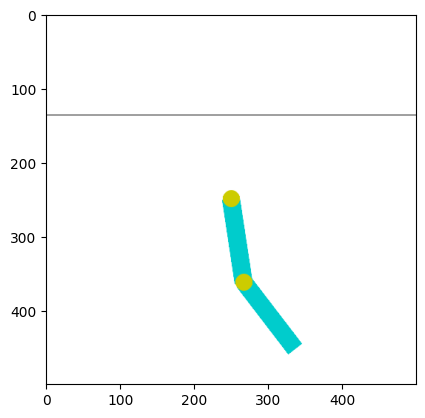

In [2]:
# Create the environment
env = gym.make('Acrobot-v1', render_mode="rgb_array")

# Reset the environment
observation = env.reset()

# Create a figure and axis object
fig, ax = plt.subplots()

# Main loop
while True:
    # Render the environment
    ax.imshow(env.render())

    # Take a random action
    action = env.action_space.sample()

    # Step the environment
    observation, reward, done, trunc, info = env.step(action)
    done = done or trunc

    # Check if the game is over
    if done:
        break

# Close the environment
env.close()

# Show the plot
plt.show()

##### Step 3: We then set up the device 

The environment is created using `gym.make('Acrobot-v1')`, and the `reset()` function is used to initialize the game state. The main loop of the game is implemented using a while loop, in which the environment is rendered, a random action is taken, and the environment is stepped using env.step(action).

In [3]:
# Create the environment
env = gym.make("Acrobot-v1")

# Set up matplotlib for interactive plotting
# (for use in Jupyter notebooks or IPython)
is_ipython = "inline" in plt.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# Set up the device to use (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(device)

cuda


We used the `device` variable to later move the neural network and other tensors to the specified device, ensuring that the computations are performed on the selected hardware. This can significantly speed up the training process, especially when dealing with large neural networks and datasets.

##### Step4:  Building the Deep Q-Network

The DQN architecture is defined in the DQN class, which is a neural network with three layers: two hidden layers with 128 neurons each and one output layer with the number of neurons equal to the number of actions. The forward() function defines the forward pass through the network.

In [4]:
class DQN(nn.Module):
    """
    Deep Q-Network (DQN) class.

    Parameters:
        n_observations (int): Number of observations (input size).
        n_actions (int): Number of possible actions (output size).
    """

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128) # First hidden layer with 128 neurons
        self.layer2 = nn.Linear(128, 128) # Second hidden layer with 128 neurons
        self.layer3 = nn.Linear(128, n_actions) # Output layer with n_actions neurons

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
            x (tensor): Input tensor with shape (batch_size, n_observations).

        Returns:
            tensor: Output tensor with shape (batch_size, n_actions).
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


We then set up hyperparameters and initializing a reinforcement learning environment with a neural network-based policy network and a target network. 

The hyperparameters of the DQN algorithm are set as follows: `BATCH_SIZE` is the number of transitions sampled from the replay buffer, `GAMMA` is the discount factor, `EPS_START` and `EPS_END` are the starting and ending values of epsilon for the epsilon-greedy strategy, `EPS_DECAY` controls the rate of exponential decay of epsilon, `TAU` is the update rate of the target network, and `LR` is the learning rate of the optimizer.

The policy network's weights are loaded onto the target network. The code also initializes the optimizer for the policy network. Finally, the code defines a named tuple for storing the transition experiences in the replay memory.

In [5]:
# Define the hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions and state observations
n_actions = env.action_space.n
state, _ = env.reset()
n_observations = len(state)

# Initialize policy and target networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

# Load the weights of the policy network to the target network
target_net.load_state_dict(policy_net.state_dict())

# Define the replay memory transition as a named tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Initialize the optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR)

##### Step 5: Creating the Replay Memory Class and important functions

The `ReplayMemory `class is used to store transitions of states, actions, next states, and rewards to be used for experience replay. The `select_action` function implements the epsilon-greedy strategy for selecting actions. The `plot_durations` function is used to plot the duration of each episode during training.

In [6]:
class ReplayMemory(object):
    """Replay Memory implementation to store transitions and sample from them"""
    
    def __init__(self, capacity):
        """Initialize the Replay Memory
        
        Args:
        capacity (int): Maximum capacity of the Replay Memory
        """
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition
        
        Args:
        *args: Tuple of state, action, next state, and reward
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a random batch of transitions
        
        Args:
        batch_size (int): Number of transitions to sample
        
        Returns:
        List of randomly sampled transitions from the Replay Memory
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the length of the Replay Memory"""
        return len(self.memory)


In [7]:
# Create an AdamW optimizer and pass the policy_net's parameters to it
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Initialize a replay memory with a capacity of 10000
memory = ReplayMemory(10000)

# Set the initial number of steps that the agent has taken to 0
steps_done = 0

In [8]:
def select_action(state):
    """
    Select an action to take based on the current state of the environment

    Args:
    - state (torch.tensor): current state of the environment

    Returns:
    - (torch.tensor): action to take based on the current state
    """
    global steps_done
    sample = random.random() # generate a random number between 0 and 1
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY) # calculate the threshold for exploration
    steps_done += 1
    if sample > eps_threshold: # if the random number is greater than the threshold, select the action with the highest Q-value
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # the second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else: # else, select a random action from the environment's action space
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


In [9]:
episode_durations = []

def plot_durations(show_result=False):
    """
    Plot the durations of the episodes during training.
    
    Args:
    show_result (bool, optional): Set True to display the final result plot. Defaults to False.
    """
    
    # Create a new figure or clear an existing figure
    plt.figure(1)
    
    # Convert episode_durations list to a tensor of float dtype
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    
    # Set the x and y axis labels
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    
    # Plot the episode durations
    plt.plot(durations_t.numpy())
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    # Pause for a bit so that plots are updated
    plt.pause(0.001)
    
    # If using ipython notebook, clear the output display
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


##### Step 6: Optimising  the Q-Network

Here the function `optimize_model` that optimizes the Q-Network of a reinforcement learning algorithm using backpropagation. The function does the following:

1. If there are not enough transitions stored in the memory buffer to form a minibatch, it returns without doing anything.
2. It samples a minibatch of transitions from the memory buffer.
3. It transposes the minibatch to create a batch of states, actions, rewards, and next_states.
4. It computes a mask of non-final states and concatenates the batch elements.
5. It computes Q(s_t, a) - the model computes Q(s_t), then selects the columns of actions taken.
6. It computes V(s_{t+1}) for all next states.
7. It computes the expected Q values.
8. It computes the Huber loss between the current state-action values and the expected state-action values.
9. It optimizes the model using backpropagation by setting the optimizer gradients to zero, computing gradients of the loss with respect to the network parameters, and updating the parameters using the optimizer. The function also performs in-place gradient clipping to prevent the gradients from getting too large.






In [10]:
def optimize_model():
    """
    This function optimizes the Q-Network by performing backpropagation and updating the network's parameters. 
    It relies on the global variables defined in the main function.

    Returns:
        None
    """
    # If there are not enough transitions stored in the memory buffer to form a minibatch, return without doing anything
    if len(memory) < BATCH_SIZE:
        return
    
    # Sample a minibatch of transitions from the memory buffer
    transitions = memory.sample(BATCH_SIZE)

    # Transpose the minibatch to create a batch of states, actions, rewards, and next_states
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch) # current Q

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch # r + dis * Q(s')

    # Compute the Huber loss between the current state-action values and the expected state-action values
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()   # Set optimizer gradients
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


##### Step : Training the Reinforcement Learning Agent

We implementing the training loop for a reinforcement learning agent. The agent interacts with an environment in a loop of episodes, each episode consisting of several time steps. During each time step, the agent selects an action according to its current policy, takes that action in the environment, and receives a reward and the next state from the environment. The agent stores the transition in a memory buffer and uses it to update its Q-network by performing backpropagation and optimization. The target network's weights are also updated by a soft update. The loop continues until the maximum number of episodes is reached. Finally, the episode durations are plotted, and the training is completed.




Episode 500/500: Average Reward = -0.99, Optimal Action Percentage = 96.34%
Complete


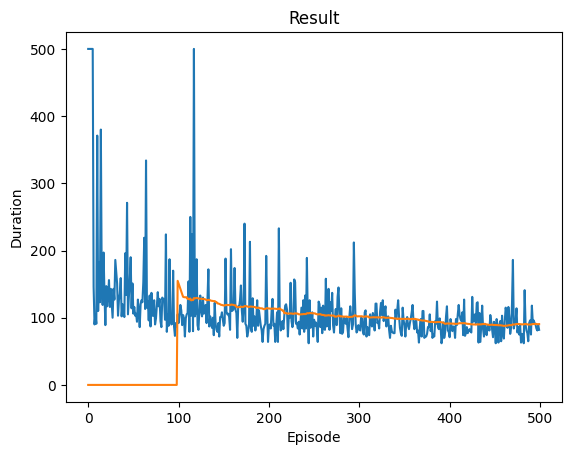

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 500
# Initialize lists to store average rewards and optimal action percentages
average_rewards = []
optimal_action_percentages = []
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    optimal_action_count = 0
    total_reward = 0

    for t in count():
        # Choose the next action using the current policy network
        action = select_action(state)

        # Check if the selected action is optimal
        with torch.no_grad():
            optimal_action = policy_net(state).max(1)[1].view(1, 1)
        if action == optimal_action:
            optimal_action_count += 1

        # Take the action and observe the next state, reward, and termination signal
        observation, reward, terminated, trunc, _ = env.step(action.item())
        done = terminated or trunc
        total_reward += reward
        reward = torch.tensor([reward], device=device)

        # Set the next state to None if the game is over, otherwise convert the observation to a tensor and unsqueeze it
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization on the policy network
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        # Check if the game is over
        if done:
            # Add the episode duration to the list of durations and plot them
            episode_durations.append(t + 1)
            print(episode_durations[-1])
            plot_durations()

            # End the episode
            break

    # Calculate the average reward for this episode
    average_reward = total_reward / (t + 1)
    average_rewards.append(average_reward)

    # Calculate the optimal action percentage for this episode
    optimal_action_percentage = (optimal_action_count / (t + 1)) * 100
    optimal_action_percentages.append(optimal_action_percentage)

    print(f"Episode {i_episode + 1}/{num_episodes}: Average Reward = {average_reward:.2f}, Optimal Action Percentage = {optimal_action_percentage:.2f}%")

# End of the training
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

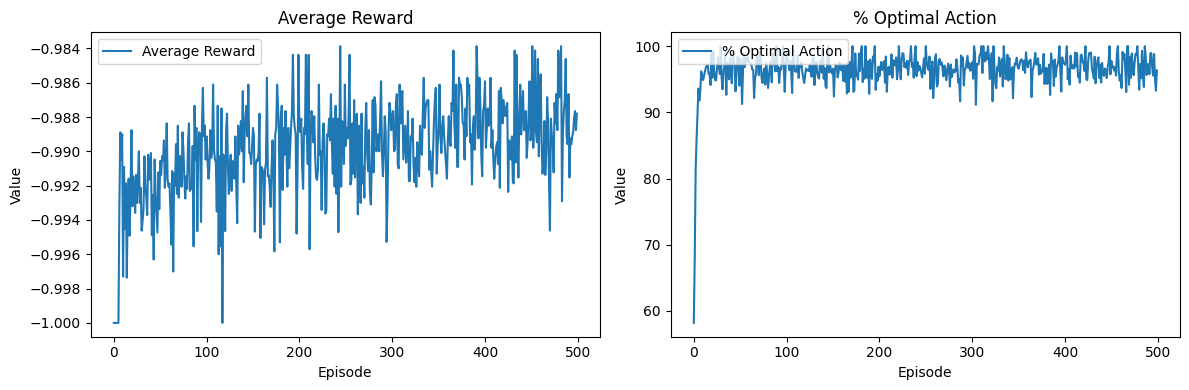

In [12]:
# Function to plot average rewards and optimal action percentages in subplots
def plot_metrics():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.set_title("Average Reward")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Value")
    ax1.plot(average_rewards, label="Average Reward")
    ax1.legend(loc="upper left")
    
    ax2.set_title("% Optimal Action")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Value")
    ax2.plot(optimal_action_percentages, label="% Optimal Action")
    ax2.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics()


In [21]:
# Initialize the environment
env = gym.make("Acrobot-v1", render_mode='rgb_array')
frames = []
for i in range(1):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    done = False
    score = 0

    while not done:
        frames.append(env.render())
        action = select_action(state)
        next_state, reward, done, trunc, _ = env.step(action.item())
        done = done or trunc
        score += reward
        state = next_state
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

env.close()
    

C:\Users\Excalibur\anaconda3\envs\myenv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [22]:
def create_animation(frames):
    fig, ax = plt.subplots()
    im = ax.imshow(frames[0])  # İlk kareyi göstererek başlıyoruz
    
    # Her kareyi güncelleyen işlev
    def update(frame):
        im.set_data(frame)  # Görüntüyü günceller
        return im,

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=50, blit=True)
    plt.close(fig)  # Çıktıyı kontrol defterinde görmek için figürü kapatıyoruz
    return HTML(ani.to_html5_video())

# Animasyonu oluştur ve görüntüle
create_animation(frames)

In [ ]:
print(type(HTML))